# Draw pairs of mass and redshift according to a mass function (computed with either CCL or NumCosmo)

In [1]:
import sys
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy 
%matplotlib inline

In [2]:
# NumCosmo imports
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

## Mass function - CCL implementation

In [3]:
cosmo = ccl.Cosmology(Omega_c=0.26, Omega_b=0.04,
                      h=0.7, sigma8=0.8, n_s=0.96, Neff=3.04,  m_nu=1.0e-05, m_nu_type="single")
hmd_200c = ccl.halos.MassDef(200, 'critical') 
def tinker08_ccl(logm, z):
    mass = 10**(logm)
    hmf_200c = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200c)
    nm = hmf_200c.get_mass_function(cosmo, mass, 1./(1+z))
    return nm # dn/dlog10M

def dV_over_dOmega_dz(z):
    a = 1./(1. + z)
    da = ccl.background.angular_diameter_distance(cosmo, a) 
    E = ccl.background.h_over_h0(cosmo, a)
    return ((1.+z)**2)*(da**2)*ccl.physical_constants.CLIGHT_HMPC/cosmo['h']/E 

def pdf_tinker08_ccl(logm,z):
    return tinker08_ccl(logm, z)*dV_over_dOmega_dz(z)


## Mass function - Numcosmo implementation

In [4]:
Ncm.cfg_init ()
#cosmo_nc = Nc.HICosmoDEXcdm()
cosmo_nc = Nc.HICosmo.new_from_name(
    Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<1>}")
cosmo_nc.omega_x2omega_k()
cosmo_nc.param_set_by_name("w0", -1.0)
cosmo_nc.param_set_by_name("w1", 0.0)
cosmo_nc.param_set_by_name("Tgamma0", 2.725)
cosmo_nc.param_set_by_name("massnu_0", 0.0)
cosmo_nc.param_set_by_name("H0", 70.)
cosmo_nc.param_set_by_name("Omegab", 0.04)
cosmo_nc.param_set_by_name("Omegac", 0.26)
cosmo_nc.param_set_by_name("Omegak", 0.0)


# ENnu = 3.046 - 3.0 * \
#     cosmo_nc.E2Press_mnu(1.0e10) / (cosmo_nc.E2Omega_g(1.0e10)
#                                  * (7.0/8.0*(4.0/11.0)**(4.0/3.0)))

ENnu = 3.046
cosmo_nc.param_set_by_name("ENnu", ENnu)
reion = Nc.HIReionCamb.new () 
prim = Nc.HIPrimPowerLaw.new () 

cosmo_nc.add_submodel (reion)
cosmo_nc.add_submodel (prim)

dist = Nc.Distance.new (2.0)
dist.prepare_if_needed(cosmo_nc)
tf = Nc.TransferFunc.new_from_name ("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new (tf)
psml.require_kmin (1.0e-6)
psml.require_kmax (1.0e3)

psf = Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0 ()

prim.props.n_SA = 0.96

old_amplitude = np.exp (prim.props.ln10e10ASA)
prim.props.ln10e10ASA = np.log ((0.8 / cosmo_nc.sigma8(psf))**2 * old_amplitude)
print(0.8, cosmo_nc.sigma8(psf))

mulf = Nc.MultiplicityFuncTinker.new ()
mulf.set_mdef (Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta (200.0)
mf = Nc.HaloMassFunction.new (dist, psf, mulf)
#
# New mass function object using the objects defined above.
#
def tinker08_nc(logm, z):
    lnm = logm * np.log(10.) # convert log10(M) to ln(M) 
    res = mf.dn_dlnM(cosmo_nc, lnm, z)
    return res * np.log(10.) # convert dn/dlnM to dn/dlog10M

def pdf_tinker08_nc(logm, z):
    return tinker08_nc(logm, z)*mf.dv_dzdomega(cosmo_nc, z)

0.8 0.8


## Compare the CCL and NC implementations

### Volume element

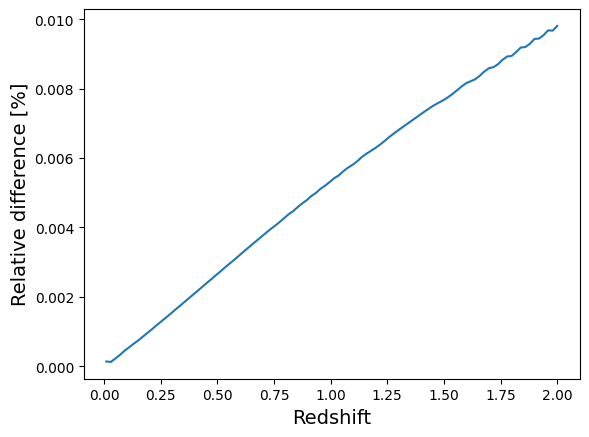

In [5]:
z_arr = np.linspace(0.01, 2, 100)
v_nc = [mf.dv_dzdomega(cosmo_nc, z) for z in z_arr]
v_ccl = dV_over_dOmega_dz(z_arr)
plt.plot(z_arr, np.abs(v_nc/v_ccl -1)*100);
plt.xlabel('Redshift', size=14);
plt.ylabel('Relative difference [%]', size=14);

### Mass function

The CCL and Numcosmo implementations give different results for the Tinker08 HMF, especially at high redshift (>1.5). Need to understand why, although it is not a regime we should find ourselves in with cluster studies at optical wavelength. Might be that the CCL and NC cosmologies defined above are not actually the same (neutrinos?).

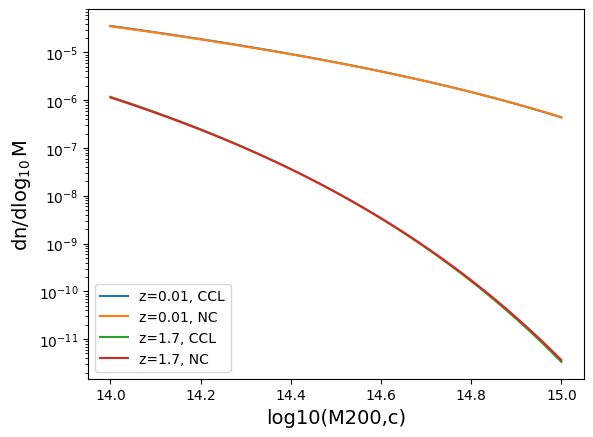

In [6]:
logm_arr=np.linspace(14.,15)
z_arr = np.linspace(0.01, 1.7, 2)

t08_vec_ccl=np.vectorize(tinker08_ccl)
t08_vec_nc=np.vectorize(tinker08_nc)
for z in z_arr:
    res_ccl = t08_vec_ccl(logm_arr,z)
    res_nc = t08_vec_nc(logm_arr,z)
    plt.plot(logm_arr, res_ccl, label=f'z={z}, CCL');
    plt.plot(logm_arr, res_nc, label=f'z={z}, NC');
    plt.yscale('log');
    plt.xlabel('log10(M200,c)', size=14);
    plt.ylabel('dn/d$\log_{10}$M', size=14);
plt.legend();

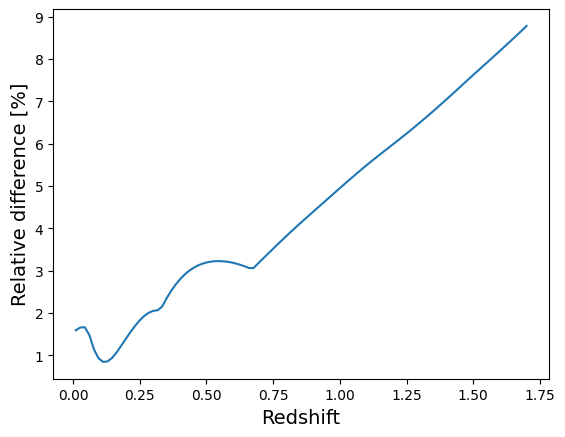

In [7]:
z_arr = np.linspace(0.01, 1.7, 100)
logm = 15.
res_ccl = t08_vec_ccl(logm,z_arr)
res_nc = t08_vec_nc(logm,z_arr)
plt.plot(z_arr, np.abs(res_ccl/res_nc -1)*100);
plt.xlabel("Redshift", size=14);
plt.ylabel("Relative difference [%]", size=14);

## Acceptance-rejection method to sample (M,z) from the mass function

In [8]:
def bivariate_draw(pdf, N=1000,logm_min=14.,logm_max=15., zmin=0.01, zmax=1, Ngrid_m=30, Ngrid_z=30):  
    """  
    Uses the rejection method for generating random numbers derived from an arbitrary   
    probability distribution. 

    Parameters
    ----------
    pdf : func
      2d distribution function to sample
    N : int
      number of points to generate  
    log_min,logm_max : float 
      log10 mass range  
    zmin,zmax : float 
      redshift range  

    Returns:   
    --------
    ran_logm : list
        accepted logm values  
    ran_z : list
        accepted redshift values
    acceptance : float
        acceptance ratio of the method
    """  

    # maximum value of the pdf over the mass and redshift space.
    # the pdf is not monotonous in mass and redshift, so we need
    # to find the maximum numerically. Here we scan the space
    # with a regular grid and use the maximum value.
    # Accuracy of the results depends on Ngrid_m and Ngrid_z 
    # This should probably be improved
    
    logM_arr = np.linspace(logm_min, logm_max, Ngrid_m)  
    z_arr = np.logspace(np.log10(zmin), np.log10(zmax), Ngrid_z)  
    p = []
    for logM in logM_arr:
        for z in z_arr:
            p.append(pdf(logM, z))  
    pmax = np.max(p)
    pmin = np.min(p)
    # Counters  
    naccept = 0  
    ntrial = 0  

    # Keeps drawing until N points are accepted  
    ran_logm = [] # output list of random numbers  
    ran_z = [] # output list of random numbers  
    while naccept < N:  
        # draw (logm,z) from uniform distribution
        # draw p from uniform distribution
        logm = np.random.uniform(logm_min,logm_max) # x'  
        z = np.random.uniform(zmin,zmax) # x'  
        p = np.random.uniform(pmin,pmax) # y'  

        if p < pdf(logm, z):  
            # keep the point
#            print(logm, z, p, pdf(logm, z))
            ran_logm.append(logm)  
            ran_z.append(z)  
            naccept = naccept+1  
        ntrial = ntrial+1  

    ran_logm = np.asarray(ran_logm)  
    ran_z = np.asarray(ran_z)  

    acceptance = float(N/ntrial)
    print(f"acceptance = {acceptance}")
    return ran_logm, ran_z, acceptance

## Draw (M,z) pairs and check consistency with mass function

In [9]:
# Define the numbers of pairs to draw and the mass and redshift ranges
N = 400
logm_min = 14.
logm_max = 14.5
zmin = 0.2
zmax = 1.

# Choose between the CCL and NC implementation (NC is faster)
#pdf = pdf_tinker08_ccl
pdf = pdf_tinker08_nc

In [10]:
# Normalisation factor for the pdf to be used later
norm = 1./scipy.integrate.dblquad(pdf, zmin, zmax, lambda x:logm_min, lambda x:logm_max, epsrel=1.e-4)[0]

In [11]:
# Random draw
ran_logm, ran_z, acceptance = bivariate_draw(pdf, N=N,logm_min=logm_min,logm_max=logm_max, zmin=zmin, zmax=zmax)

acceptance = 0.29739776951672864


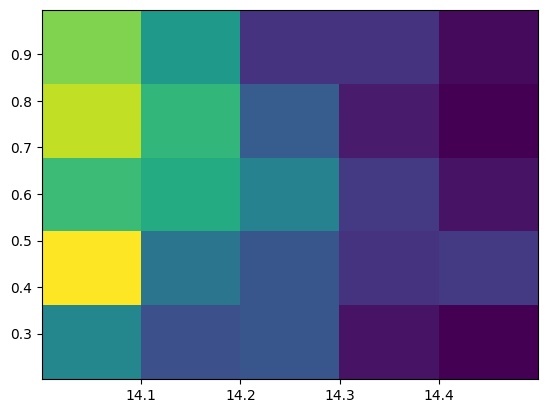

In [12]:
plt.hist2d(ran_logm, ran_z, bins=5);

## Check distribution in mass bins (integrate over the full redshift range)

[14.00003249 14.04995439 14.09987628 14.14979818 14.19972007 14.24964197
 14.29956386 14.34948576 14.39940765 14.44932955 14.49925144]


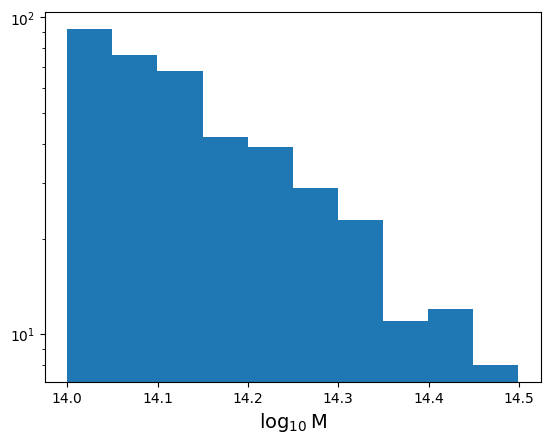

In [13]:
hist_m = plt.hist(ran_logm, bins=10);
plt.yscale('log');
plt.xlabel('$\log_{10}$M', size=14);
print(hist_m[1])

In [14]:
print(zmin, zmax)
predicted_T08_m_quad=[]
for i in np.arange(len(hist_m[0])):
    lmmin = hist_m[1][i]
    lmmax = hist_m[1][i+1]
    N_T08 =  norm * N * scipy.integrate.dblquad(pdf, zmin, zmax, lambda x:lmmin, lambda x:lmmax, epsrel=1.e-4)[0]
    predicted_T08_m_quad.append(N_T08) 


0.2 1.0


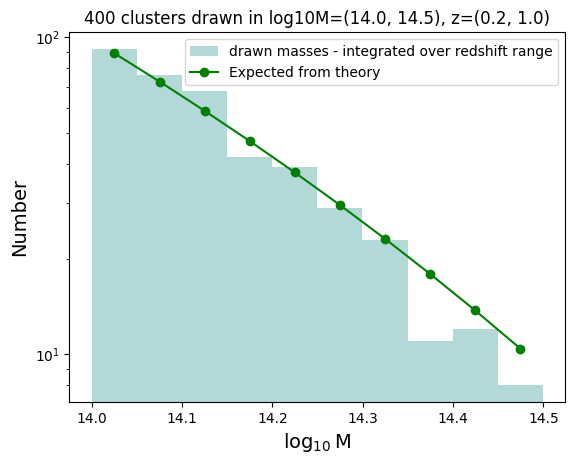

In [15]:
bin_centers_m=[(hist_m[1][i]+hist_m[1][i+1])/2. for i in np.arange(len(hist_m[0]))]

hist_m = plt.hist(ran_logm, bins=10, color='teal', alpha=0.3, label='drawn masses - integrated over redshift range');
plt.plot(bin_centers_m,np.array(predicted_T08_m_quad), '-o',color='green', label='Expected from theory');
plt.yscale('log');
plt.xlabel('$\log_{10}$M', size=14);
plt.ylabel('Number', size=14);
plt.title(f'{N} clusters drawn in log10M={logm_min, logm_max}, z={zmin, zmax}');
plt.legend();

## Check distribution in redshift bins (integrate over the full mass range)

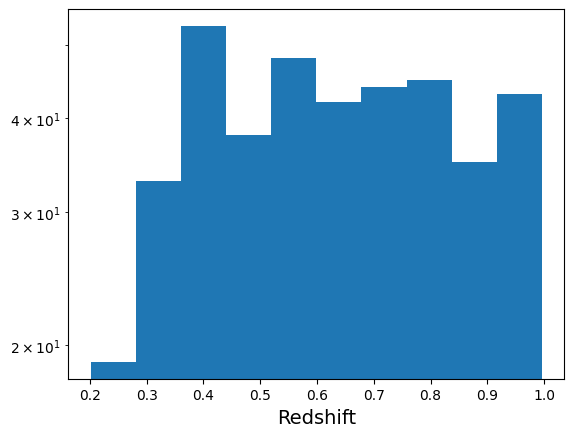

In [16]:
hist_z = plt.hist(ran_z, bins=10);
plt.yscale('log');
plt.xlabel('Redshift', size=14);

In [17]:
print(logm_min, logm_max)
predicted_T08_z_quad=[]
for i in np.arange(len(hist_z[0])):
    zzmin = hist_z[1][i] 
    zzmax = hist_z[1][i+1]
    N_T08 = norm * N * scipy.integrate.dblquad(pdf, zzmin, zzmax, lambda x:logm_min, lambda x:logm_max, epsabs=1.e-4, epsrel=1.e-4)[0]
    predicted_T08_z_quad.append(N_T08) 


14.0 14.5


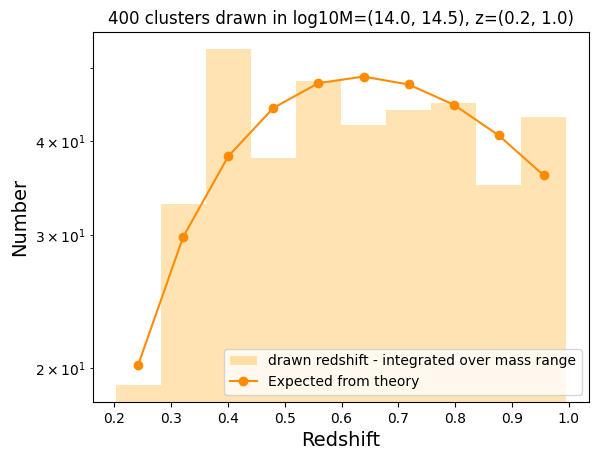

In [18]:
bin_centers_z=[(hist_z[1][i]+hist_z[1][i+1])/2. for i in np.arange(len(hist_z[0]))]

hist_z = plt.hist(ran_z, bins=10, color='orange', alpha=0.3, label='drawn redshift - integrated over mass range');
plt.plot(bin_centers_z,np.array(predicted_T08_z_quad), '-o',color='darkorange', label='Expected from theory');
plt.yscale('log');
plt.xlabel('Redshift', size=14);
plt.ylabel('Number', size=14);
plt.title(f'{N} clusters drawn in log10M={logm_min, logm_max}, z={zmin, zmax}');
plt.legend(loc=4);

## Creating ClusterEnsemble object and estimation of individual excess surface density profiles

In [19]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData
from clmm import Cosmology
from clmm.support import mock_data as mock

In [20]:
# random draw in the mass and redshift range (for simplicity, uniform instead of following an actual mass function)
cluster_m = 10 **ran_logm
cluster_z =  ran_z
print(min(cluster_z), max(cluster_z))

conc_obj = ccl.halos.ConcentrationDuffy08(hmd_200c)
conc_list = []
for number in range (0, len(cluster_m)):
    a = 1./(1. + (cluster_z[number]))
    conc_list.append(conc_obj.get_concentration(cosmo, M = (cluster_m[number]),a = a))  
    
c_list  = np.array(conc_list)


# randomly draw cluster positions on the sky
ra = np.random.random(N) * 360 #from 0 to 360 deg
sindec = np.random.random(N) * 2 - 1
dec = np.arcsin(sindec) * 180 / np.pi #from -90 to 90 deg

0.20195382817747812 0.9958711593764658


### Mock Galaxy Genaration

In [21]:
gclist = []
# number of galaxies in each cluster field (alternatively, can use the galaxy density instead)
n_gals = 100
#ngal_density = 10
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_clmm.set_be_cosmo(cosmo)
for i in range(N):
    # generate background galaxy catalog for cluster i
    noisy_data_z = mock.generate_galaxy_catalog(cluster_m[i], cluster_z[i], conc_list[i], cosmo_clmm, 
                                                cluster_ra=ra[i], cluster_dec=dec[i],
                                                zsrc = 'chang13', 
                                                delta_so=200, 
                                                massdef='critical',
                                                halo_profile_model='nfw', 
                                                zsrc_min= cluster_z[i] + 0.1,
                                                zsrc_max=3.0, 
                                                field_size=10., 
                                                shapenoise=.04, 
                                                photoz_sigma_unscaled=0.02, 
                                                ngals=n_gals,
                                                mean_e_err=.1)
    print(i)

    cl = clmm.GalaxyCluster('mock_cluster', ra[i], dec[i], cluster_z[i], noisy_data_z)

    # compute DeltaSigma for each background galaxy
    cl.compute_tangential_and_cross_components(shape_component1='e1', shape_component2='e2', 
                                               tan_component='DS_t', cross_component='DS_x',
                                               cosmo=cosmo_clmm, is_deltasigma=True, use_pdz=True)
    
    # compute the weights to be used to bluid the DeltaSigma radial profiles
    cl.compute_galaxy_weights(use_pdz = True,
    use_shape_noise = True, shape_component1 = 'e1', shape_component2 = 'e2', 
    use_shape_error = True, shape_component1_err = 'e_err', shape_component2_err = 'e_err', 
    weight_name = 'w_ls', cosmo = cosmo, is_deltasigma = True, add = True)

    # append the cluster in the list
    gclist.append(cl)

/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

0
1
2
3
4
5
6
7
8


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

9
10
11
12
13
14
15
16
17


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

18
19
20
21
22
23
24
25
26
27


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

28
29
30
31
32
33
34
35


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


36
37


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

38
39
40
41
42
43
44
45


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


46
47


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

48
49
50
51
52
53
54
55


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


56
57


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

58
59
60
61
62
63
64
65


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


66
67


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

68
69
70
71
72
73
74
75


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


76
77


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

78
79
80
81
82
83
84
85


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


86
87


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

88
89
90
91
92
93
94
95


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


96
97


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

98
99
100
101
102
103
104
105


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


106
107


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

108
109
110
111
112
113
114
115


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


116
117


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

118
119
120
121
122
123
124


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


125
126


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

127
128
129
130
131
132
133
134


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


135
136


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

137
138
139
140
141
142
143
144


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


145
146


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

147
148
149
150
151
152
153
154


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


155
156


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

157
158
159
160
161
162
163
164
165


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


166
167


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

168
169
170
171
172
173
174
175
176


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


177


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

178
179
180
181
182
183
184
185
186
187
188


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

189
190
191
192
193
194
195
196
197
198


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

199
200
201
202
203
204
205
206
207
208


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

209
210
211
212
213
214
215
216
217
218


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

219
220
221
222
223
224
225
226
227
228


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

229
230
231
232
233
234
235
236
237
238


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

239
240
241
242
243
244
245
246
247
248


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

249
250
251
252
253
254
255
256
257
258


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

259
260
261
262
263
264
265
266
267
268


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

269
270
271
272
273
274
275
276
277


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

278
279
280
281
282
283
284
285
286
287


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

288
289
290
291
292
293
294
295
296
297


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

298
299
300
301
302
303
304
305
306
307


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

308
309
310
311
312
313
314
315
316
317


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

318
319
320
321
322
323
324
325
326
327


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

328
329
330
331
332
333
334
335
336
337


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

338
339
340
341
342
343


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

344
345
346
347
348
349
350
351
352
353


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

354
355
356
357
358
359
360
361
362


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

363
364
365
366
367
368
369
370
371


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

372
373
374
375
376
377
378
379
380


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

381
382
383
384
385
386
387
388
389
390


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

391
392
393
394
395
396
397
398
399


/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


In [22]:
cl.galcat.columns

<TableColumns names=('ra','dec','e1','e2','e_err','z','ztrue','pzbins','pzpdf','id','sigma_c','theta','DS_t','DS_x','w_ls')>

## Creating ClusterEnsemble object and estimation of individual excess surface density profiles

In [23]:
ensemble_id = 1
names = ['id', 'ra', 'dec', 'z', 'radius', 'gt', 'gx', 'W_l']
bins = np.logspace(np.log10(0.3),np.log10(5),10)
clusterensemble = ClusterEnsemble(ensemble_id, gclist, 
                                  tan_component_in='DS_t', cross_component_in='DS_x', 
                                  tan_component_out='DS_t', cross_component_out='DS_x', 
                                  weights_in = 'w_ls', weights_out = 'W_l', 
                                  bins=bins, bin_units='Mpc', cosmo=cosmo_clmm)

In [24]:
clusterensemble.make_stacked_radial_profile(tan_component='DS_t', cross_component='DS_x')

In [80]:
def bivariate_draw_from_concentration(pdf, N=1000,logm_min=14.,logm_max=20., zmin=0.01, zmax=1., Ngrid_m=100, Ngrid_z=100, standard_deviation = 0.0001):  
    """  
    Uses the rejection method for generating random numbers derived from a concentration 
    probability distribution. 

    Parameters
    ----------
    pdf : func
      2d distribution function to sample
    N : int
      number of points to generate  
    log_min,logm_max : float 
      log10 mass range  
    zmin,zmax : float 
      redshift range  
    standard_deviation : float
      Defines the standard deviation used on the gaussian \
      to generated scattered data from the concentrations
      
    Returns:   
    --------
    ran_logm : list
        accepted logm values  
    ran_z : list
        accepted redshift values
    acceptance : float
        acceptance ratio of the method
    """  

    # maximum value of the pdf over the mass and redshift space.
    # the pdf is not monotonous in mass and redshift, so we need
    # to find the maximum numerically. Here we scan the space
    # with a regular grid and use the maximum value.
    # Accuracy of the results depends on Ngrid_m and Ngrid_z 
    # This should probably be improved
    
    logM_arr = np.linspace(logm_min, logm_max, Ngrid_m)  
    z_arr = np.logspace(np.log10(zmin), np.log10(zmax), Ngrid_z)  
    p = []
    for logM in logM_arr:
        for z in z_arr:
            mean_c = np.log(pdf(logM, z))
            log_c = np.random.normal(mean_c, standard_deviation)
            c = np.exp(log_c)
            p.append(c)
    pmax = np.max(p) 
    pmin = min(p)
    print(pmax, pmin)
    # Counters  
    naccept = 0  
    ntrial = 0  

    # Keeps drawing until N points are accepted  
    ran_logm = [] # output list of random numbers  
    ran_z = [] # output list of random numbers  
    ran_c = []
    while naccept < N:  
        # draw (logm,z) from uniform distribution
        # draw p from uniform distribution
        logm = np.random.uniform(logm_min,logm_max) # x'  
        z = np.random.uniform(zmin,zmax) # x'  
        p = np.random.uniform(pmin,pmax) # y'  
        mean_c = np.log(pdf(logm, z))
        log_c = np.random.normal(mean_c, standard_deviation)
        c = np.exp(log_c)
        print(p,c)
        if p < c:  
            # keep the point
#            print(logm, z, p, pdf(logm, z))
            ran_logm.append(logm)  
            ran_z.append(z)
            ran_c.append(c)
            naccept = naccept+1  
        ntrial = ntrial+1  

    ran_logm = np.asarray(ran_logm)  
    ran_z = np.asarray(ran_z)  

    acceptance = float(N/ntrial)
    print(f"acceptance = {acceptance}")
    return ran_logm, ran_z, ran_c, acceptance

In [81]:
def concentration_pdf (logm, z):
    conc_obj = ccl.halos.ConcentrationDuffy08(hmd_200c)
    a = 1./(1. + z)
    return conc_obj.get_concentration(cosmo, M = np.exp(logm),a = a)  
ran_logm, ran_z, ran_c, acceptance = bivariate_draw_from_concentration(concentration_pdf)
print(max(ran_c))


19.503707513637664 8.54863870574688
17.919350855736706 13.858531590152598
8.723548027773454 11.04278653763811
15.174149579566546 9.541549865747227
10.762022455315806 15.479699403986793
10.439934473805172 14.941552296742074
14.91648484927954 12.337027013426676
10.794227108590754 14.404368781063917
14.490629663774662 13.85197915986414
13.699144639449198 13.72974206204199
18.952978571691695 10.209571296477721
12.798645114332494 8.91103506364857
11.631454504241898 15.134469502471614
18.736442924368404 9.61751841504722
10.433015926443332 11.189511000979676
10.306204218720742 12.575115947164116
13.824978743438017 12.96775684306855
16.084323583706038 11.322217161588682
12.388384769042176 10.953167984366628
18.410816351014084 11.714452332227658
15.046814563130694 10.924471117920167
12.663189358617817 15.60827307380778
10.049988297648643 9.765690458354044
18.949323522821835 16.94469781345854
14.019968452617046 11.851221161354596
10.777882170782338 13.591952176553933
8.667704663719153 10.7626297

[14.00031234 14.59917187 15.1980314  15.79689094 16.39575047 16.99461
 17.59346953 18.19232907 18.7911886  19.39004813 19.98890767]


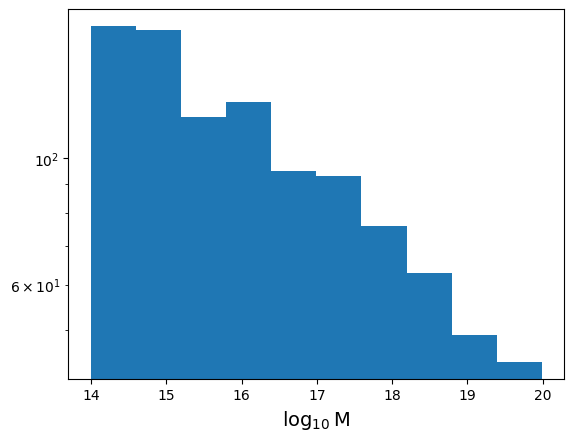

In [82]:
hist_m = plt.hist(ran_logm, bins=10);
plt.yscale('log');
plt.xlabel('$\log_{10}$M', size=14);
print(hist_m[1])

[0.01088517 0.10975249 0.20861982 0.30748715 0.40635447 0.5052218
 0.60408912 0.70295645 0.80182378 0.9006911  0.99955843]


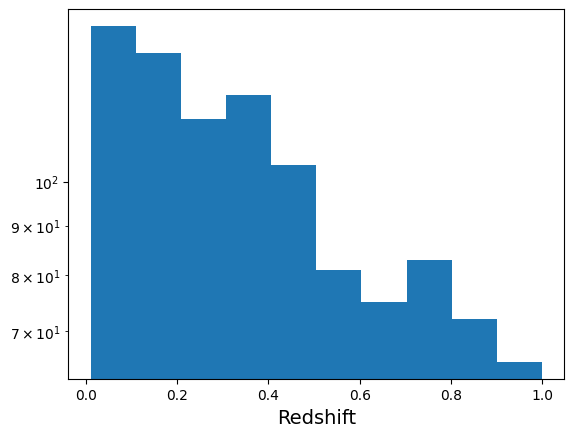

In [83]:
hist_m = plt.hist(ran_z, bins=10);
plt.yscale('log');
plt.xlabel('Redshift', size=14);
print(hist_m[1])

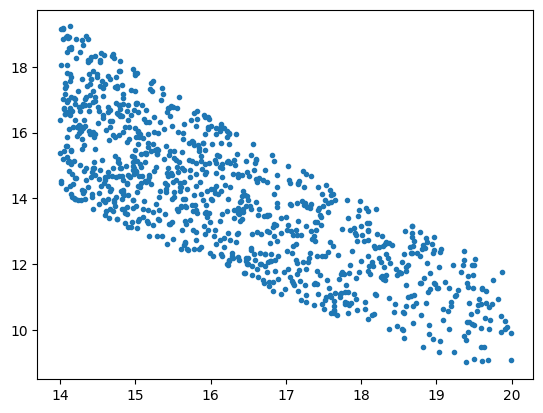

In [84]:
plt.plot(ran_logm, (ran_c), '.')